In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from matplotlib import dates
from datetime import datetime
from geopy.geocoders import Nominatim
from collections import defaultdict, Counter
import seaborn as sns
import re
from sklearn import svm
from sklearn import model_selection
import json

%matplotlib inline

In [2]:
sns.set()

In [3]:
def passenger_key(keys, year):
    for key in keys:
        if 'Passengers {:d}'.format(year) in key or 'PASSENGERS' in key:
            return key
        
    raise IndexError


def code_key(keys):
    for key in keys:
        if 'CODE' in key.upper():
            return key
        
    raise IndexError


In [4]:
# http://www.aci-na.org/content/airport-traffic-reports
top_airports = {}

for year in [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]:
    top_airports[year] = {}
    try:
        _top_airports = pd.read_excel('Data/nam{:d}_top_50.xls'.format(year))
    except FileNotFoundError:
        try:
            _top_airports = pd.read_excel('Data/nam{:d}_top_50.xlsx'.format(year))
        except FileNotFoundError(e):
            raise e
            
    #print(year, _top_airports.columns)
    passenger_column = passenger_key(_top_airports.columns, year)
    code_column = code_key(_top_airports.columns)

    for code, passengers in zip(_top_airports[code_column], _top_airports[passenger_column]):
        #print(code, passengers)
        if pd.isnull(code) or pd.isnull(passengers):
            continue
        if len(code) > 3:
            m = re.search(".*\((.{3})\)", code)
            if m is not None:
                top_airports[year][m.groups(0)[0]] = passengers
        else:
            top_airports[year][code] = passengers

    #print(top_airports.keys(), passenger_key(top_airports.keys(), year), code_key(top_airports.keys()))

In [5]:
#
claims_data1 = pd.read_excel('Data/claims-2002-2006_0.xls')
claims_data2 = pd.read_excel('Data/claims-2007-2009_0.xls')
claims_data3 = pd.read_excel('Data/claims-2010-2013_0.xls')
claims_data4 = pd.read_excel('Data/claims-2014.xls')
claims_data5 = pd.read_excel('Data/claims-data-2015-as-of-feb-9-2016.xlsx')
#claims_data.append(pd.read_excel('Data/claims-2010-2013_0.xls'))

In [6]:
claims_data = pd.concat([claims_data1, claims_data2, claims_data3, claims_data4, claims_data5])
datenums = claims_data['Date Received'].map(dates.date2num, na_action='ignore')
close_amount = pd.to_numeric(claims_data['Close Amount'], errors='coerce')*(claims_data['Status'] != 'Denied')


In [7]:
claims_data['Status'].value_counts()

Denied                                                                                                                           68339
Approved                                                                                                                         34999
Settled                                                                                                                          27958
Canceled                                                                                                                          7018
Insufficient, one of the following items required: sum certain, statement of fact, signature, location of incident, and date.     5381
Closed as a contractor claim                                                                                                      1315
In litigation                                                                                                                      108
Claim entered                                          

In [8]:
value_counts = claims_data['Claim Type'][(claims_data['Status'] == 'Approved') |
                                         (claims_data['Status'] == 'Settled')].value_counts()

In [9]:
_data = []
for value in value_counts.index.tolist():
    _data.append(claims_data['Close Amount'][(claims_data['Claim Type'] == value)*
                                        ((claims_data['Status'] == 'Approved') |
                                         (claims_data['Status'] == 'Settled'))])


/usr/local/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


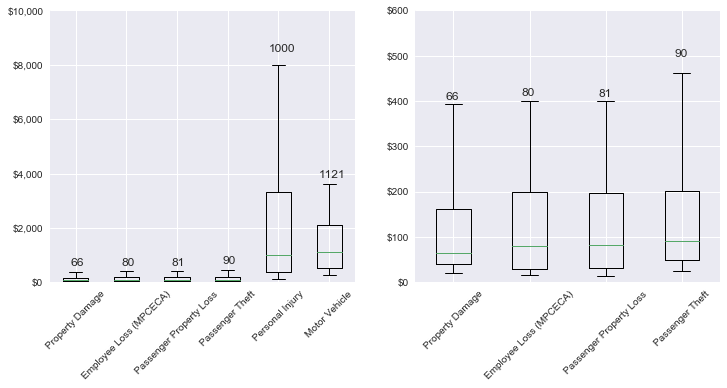

In [56]:
fmt = '${x:,.0f}'
tickfmt = mtick.StrMethodFormatter(fmt)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axis = axes[0]

labels = value_counts.index.tolist()

_data = np.array(_data)
labels = np.array(labels)

s = np.argsort(list(map(lambda x: np.median(x), _data)))

_ = axis.boxplot(_data[s], labels=labels[s],  whis=[10, 90])
axis.set_ylim([0, 10000])
for tick in axis.get_xticklabels():
    tick.set_rotation(45)
#plt.yscale('log')
#axis.set_ylabel('$USD')

for i, _datum in enumerate(_data[s]):   
    _avg = np.median(_datum)
    _max = np.percentile(_datum, 90)
    offset = 0.8 if _avg >= 1000 else 0.9
    axis.text(i+offset, _max+200, "{:1.0f}".format(_avg))

axis.yaxis.set_major_formatter(tickfmt) 
    
axis = axes[1]

_ = axis.boxplot(_data[s][:-2], labels=labels[s][:-2],  whis=[10, 90])
axis.set_ylim([0, 600])
for tick in axis.get_xticklabels():
    tick.set_rotation(45)
    
for i, _datum in enumerate(_data[s][:-2]):   
    _avg = np.median(_datum)
    _max = np.percentile(_datum, 90)
    offset = 0.8 if _avg >= 1000 else 0.9
    axis.text(i+offset, _max+10, "{:1.0f}".format(_avg))

axis.yaxis.set_major_formatter(tickfmt) 

#axis.set_ylabel('$USD')
plt.savefig('/Users/spardy/Code/Web/Blog/images/TSA/Claim_by_type.jpeg', dpi=100, bbox_inches='tight')

In [11]:
a = 1 if -1 > 0 else 2
print(a)

2


In [10]:
airport_name = {}
for _name, _code in zip(claims_data['Airport Name'], claims_data['Airport Code']):
    airport_name[_code] = _name

In [11]:
claims_by_top_airports = {}
for year in range(2006, 2016):
    claims_by_top_airports[year] = {} 
    begin = dates.date2num(datetime(year=year, month=1, day=1))
    end = dates.date2num(datetime(year=year, month=12, day=31))
    claims_by_airport = claims_data['Airport Code'][(datenums >= begin)*(datenums <= end)].value_counts()

    for key, val in claims_by_airport.iteritems():
        try:
            passengers = top_airports[year][key]
            claims_by_top_airports[year][key] = [val, passengers, val/passengers]
        except KeyError:
            print(key, val, "Airport not in top_airports")

/usr/local/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


SJU 185 Airport not in top_airports
F 157 Airport not in top_airports
RSW 138 Airport not in top_airports
PBI 118 Airport not in top_airports
BDL 114 Airport not in top_airports
RIC 102 Airport not in top_airports
ABQ 101 Airport not in top_airports
ONT 100 Airport not in top_airports
ALB 100 Airport not in top_airports
LGB 98 Airport not in top_airports
COS 97 Airport not in top_airports
CMH 91 Airport not in top_airports
GEG 86 Airport not in top_airports
ORF 84 Airport not in top_airports
ANC 80 Airport not in top_airports
SYR 79 Airport not in top_airports
OGG 78 Airport not in top_airports
RNO 78 Airport not in top_airports
BUR 77 Airport not in top_airports
OMA 71 Airport not in top_airports
KOA 70 Airport not in top_airports
OKC 70 Airport not in top_airports
JAX 68 Airport not in top_airports
ELP 66 Airport not in top_airports
MSY 64 Airport not in top_airports
TUS 63 Airport not in top_airports
BUF 62 Airport not in top_airports
MSN 61 Airport not in top_airports
MHT 58 Airpor

PGA 1 Airport not in top_airports
BRD 1 Airport not in top_airports
SHD 1 Airport not in top_airports
BKW 1 Airport not in top_airports
CIC 1 Airport not in top_airports
SLE 1 Airport not in top_airports
BHB 1 Airport not in top_airports
PIH 1 Airport not in top_airports
GYY 1 Airport not in top_airports
BRW 1 Airport not in top_airports
STC 1 Airport not in top_airports
HON 1 Airport not in top_airports
MHK 1 Airport not in top_airports
CDV 1 Airport not in top_airports
HOM 1 Airport not in top_airports
ADQ 1 Airport not in top_airports
FOE 1 Airport not in top_airports
DRT 1 Airport not in top_airports
BJI 1 Airport not in top_airports
BTM 1 Airport not in top_airports
IAG 1 Airport not in top_airports
LWB 1 Airport not in top_airports
IPT 1 Airport not in top_airports
GBD 1 Airport not in top_airports
PSG 1 Airport not in top_airports
FLO 1 Airport not in top_airports
IWD 1 Airport not in top_airports
VIS 1 Airport not in top_airports
MCN 1 Airport not in top_airports
SUX 1 Airport 

SWF 6 Airport not in top_airports
XNA 6 Airport not in top_airports
ORH 6 Airport not in top_airports
EGE 6 Airport not in top_airports
AZO 5 Airport not in top_airports
ASE 5 Airport not in top_airports
VPS 5 Airport not in top_airports
FWA 5 Airport not in top_airports
SAF 5 Airport not in top_airports
HXD 5 Airport not in top_airports
TLH 5 Airport not in top_airports
MLU 5 Airport not in top_airports
BGR 5 Airport not in top_airports
LFT 5 Airport not in top_airports
BIL 5 Airport not in top_airports
GRB 5 Airport not in top_airports
YKM 5 Airport not in top_airports
HRL 4 Airport not in top_airports
MSN 4 Airport not in top_airports
YUM 4 Airport not in top_airports
CHA 4 Airport not in top_airports
RKS 4 Airport not in top_airports
EYW 4 Airport not in top_airports
IAG 4 Airport not in top_airports
ITH 4 Airport not in top_airports
OAJ 4 Airport not in top_airports
CID 4 Airport not in top_airports
SFB 4 Airport not in top_airports
DHN 4 Airport not in top_airports
LAW 4 Airport 

BZN 9 Airport not in top_airports
CAK 9 Airport not in top_airports
SFB 9 Airport not in top_airports
FAT 9 Airport not in top_airports
PIE 8 Airport not in top_airports
BLI 8 Airport not in top_airports
HRL 8 Airport not in top_airports
RDM 7 Airport not in top_airports
SYR 7 Airport not in top_airports
GRR 7 Airport not in top_airports
BIL 7 Airport not in top_airports
ITH 6 Airport not in top_airports
SBA 6 Airport not in top_airports
MLI 6 Airport not in top_airports
GPT 6 Airport not in top_airports
ECP 6 Airport not in top_airports
SJT 6 Airport not in top_airports
MFR 6 Airport not in top_airports
AVL 6 Airport not in top_airports
CHA 6 Airport not in top_airports
MSO 6 Airport not in top_airports
SGF 6 Airport not in top_airports
IAG 6 Airport not in top_airports
ICT 6 Airport not in top_airports
FNT 6 Airport not in top_airports
ZZZ 6 Airport not in top_airports
GPI 5 Airport not in top_airports
AGS 5 Airport not in top_airports
PHF 5 Airport not in top_airports
FAR 5 Airport 

In [20]:
min_max_claims_per_year = {}

for year in range(2006, 2016):
    min_max_claims_per_year[year] = {}
    most_claims = max(claims_by_top_airports[year].items(), key=lambda kv: kv[1][2])
    least_claims = min(claims_by_top_airports[year].items(), key=lambda kv: kv[1][2])
  
    min_max_claims_per_year[year]['max'] = {}
    min_max_claims_per_year[year]['max']['name'] = airport_name[most_claims[0]]
    min_max_claims_per_year[year]['max']['code'] = most_claims[0]
    min_max_claims_per_year[year]['max']['total_passengers'] = str(most_claims[1][1])
    min_max_claims_per_year[year]['max']['total_claims'] = str(most_claims[1][0])
    min_max_claims_per_year[year]['max']['claims_pp'] = str(most_claims[1][2]*1e+5)
    
    min_max_claims_per_year[year]['min'] = {}
    min_max_claims_per_year[year]['min']['name'] = airport_name[least_claims[0]]
    min_max_claims_per_year[year]['min']['code'] = least_claims[0]
    min_max_claims_per_year[year]['min']['total_passengers'] = str(least_claims[1][1])
    min_max_claims_per_year[year]['min']['total_claims'] = str(least_claims[1][0])
    min_max_claims_per_year[year]['min']['claims_pp'] = str(least_claims[1][2]*1e+5)
    

with open('/Users/spardy/Code/Web/Blog/resources/min_max_airports.json', 'w') as f:
    f.write(json.dumps(min_max_claims_per_year))

In [21]:
min_max_claims_per_year[2006]

{'max': {'claims_pp': '1.91427078523',
  'code': 'EWR',
  'name': 'Newark International Airport',
  'total_claims': '703',
  'total_passengers': '36724167.0'},
 'min': {'claims_pp': '0.320356521213',
  'code': 'MCI',
  'name': 'Kansas City International',
  'total_claims': '36',
  'total_passengers': '11237480.0'}}

## Save locations and values to csv

In [30]:
set(claims_by_top_airports[2014].keys()).difference(set(claims_by_top_airports[2006].keys()))

{'DAL', 'MSY', 'RSW'}

In [12]:
airport_coords = {}

'IAH'

In [40]:
airport_coords['IAH'] = geolocator.geocode('George Bush Intercontinental Airport')

In [42]:
geolocator = Nominatim()
first_keys = claims_by_top_airports[2006].keys()
for year in range(2006, 2016):
    with open('/Users/spardy/Code/Web/Blog/resources/airports_{:d}.csv'.format(year), 'w') as f:
        f.write("TotalClaims,TotalPassengers,AvgClaims,Name,Code,Lat,Lon\n")
        _claims = claims_by_top_airports[year]
        for k, v in _claims.items():
                
            name = airport_name[k]

            if k in airport_coords:
                location = airport_coords[k]
            else:
                location = geolocator.geocode(name + ' Airport')
                airport_coords[k] = location

            f.write("{:2.0f},{:2.0f},{:g},{:s},{:s},{:10.13f},{:10.13f}\n".format(v[0], v[1], v[2], name, k,
                                                             location.latitude, location.longitude))


        


In [91]:
yearly_data = {}
for year in range(2002, 2016):
    begin = dates.date2num(datetime(year=year, month=1, day=1))
    end = dates.date2num(datetime(year=year, month=12, day=31))
    _data = close_amount[(datenums >= begin)*(datenums <= end)]
    yearly_data[year] = {'mean':  np.nanmean(_data),
                         'median':  np.nanmedian(_data),
                         'max':  _data.max(),
                         'num': len(_data),
                         'total': np.nansum(_data),
                         'std': np.nanstd(_data),
                         'data': _data[~np.isnan(_data)]}
    

/usr/local/lib/python3.5/site-packages/pandas/computation/expressions.py:181: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  unsupported[op_str]))


In [124]:
np.nansum(close_amount)

16234580.750000002

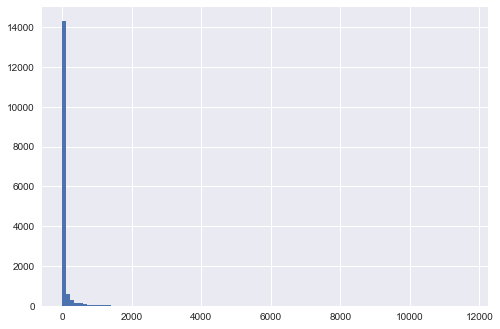

In [73]:
_ = plt.hist(yearly_data[2008]['data'], bins=100)

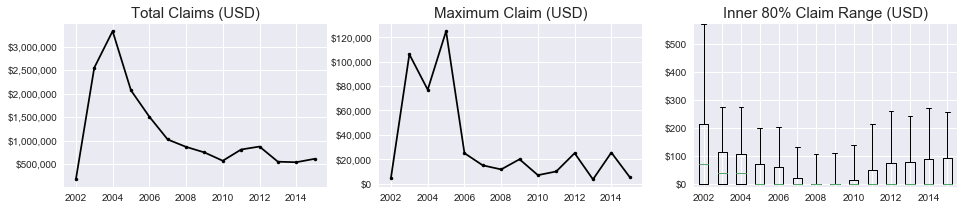

In [106]:
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)

fig, axes = plt.subplots(1, 3, figsize=(16, 3), dpi=100)
axis = axes[0]
axis.plot(range(2002, 2016), [yearly_data[year]['total'] for year in range(2002, 2016)], 'k.-')
axis.yaxis.set_major_formatter(tick) 

axis.set_title('Total Claims (USD)', fontsize=15)
#axis.set_ylabel('Total Claims (USD)', fontsize=15)

axis = axes[1]
axis.yaxis.set_major_formatter(tick) 

axis.plot(range(2002, 2016), [yearly_data[year]['max'] for year in range(2002, 2016)], 'k.-')
axis.set_title('Maximum Claim (USD)', fontsize=15)
#axis.set_ylabel('Maximum Claim (USD)', fontsize=15)

axis = axes[2]
axis.yaxis.set_major_formatter(tick) 

out = axis.boxplot([yearly_data[year]['data']
                for year in range(2002, 2016)], labels=[year if year % 2 ==0 else '' for year in range(2002, 2016)],
                      meanline=True, whis=[10, 90])
axis.set_ylim([-10, max(np.percentile(yearly_data[year]['data'], 90) for year in range(2002, 2016))])

axis.set_title('Inner 80% Claim Range (USD)', fontsize=15)
#axis.set_ylabel('Claims (USD)', fontsize=15)
plt.savefig('/Users/spardy/Code/Web/Blog/images/TSA/Total_avg_claims.jpeg', dpi=100, bbox_inches='tight')

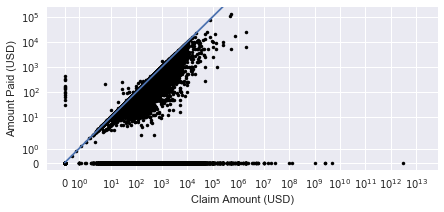

In [122]:
fig, axis = plt.subplots(1, figsize=(7, 3), dpi=100)
axis.plot(claims_data['Claim Amount'], close_amount, 'k.')
axis.set_xscale('symlog')
axis.set_yscale('symlog')
old_ylim = axis.get_ylim()
x = np.linspace(0, axis.get_xlim()[1])
axis.plot(x, x)
axis.set_ylim(*old_ylim)
axis.set_xlabel('Claim Amount (USD)')
axis.set_ylabel('Amount Paid (USD)')
plt.savefig('/Users/spardy/Code/Web/Blog/images/TSA/Claim_paid.jpeg', dpi=100, bbox_inches='tight')

In [117]:
axis.get_xlim()

(-3.8465832259992667, 74520799154867.859)

In [331]:
def nanargsort(arr):
    return np.argsort(arr[np.isfinite(arr)])

In [342]:
claims_data.iloc[np.argsort(claims_data['Claim Amount'].fillna(0))[::-1][:10]]

,Airline Name,Airport Code,Airport Name,Claim Amount,Claim Number,Claim Site,Claim Type,Close Amount,Date Received,Disposition,Incident D,Incident Date,Item,Item Category,Status
20975,NaN,JFK,John F. Kennedy International,3.000000e+12,2008012238289,Checkpoint,Personal Injury,0,2008-02-12 00:00:00,Deny,NaT,2007-12-28 00:00:00,NaN,NaN,Denied
35811,NaN,NaN,NaN,5.000000e+09,2004052653605,Other,Personal Injury,0,2004-05-26 00:00:00,NaN,NaT,2002-09-05 00:00:00,NaN,NaN,Canceled
82901,NaN,PHX,Phoenix Sky Harbor International,5.000000e+09,2006032803795,Other,Personal Injury,NaN,2006-03-27 00:00:00,Deny,NaT,2004-06-01 00:00:00,NaN,NaN,In litigation
49122,Civil Aviation - Non-Commercial Carrier,C,"Civil Aviation, Non TSA manned Airport",2.500000e+09,2004110866757,Other,Passenger Property Loss,0,2004-11-04 00:00:00,Deny,NaT,NaN,Other,NaN,Denied
50567,NaN,NaN,NaN,2.500000e+09,2004121669173,Other,Passenger Property Loss,0,2004-11-23 00:00:00,Deny,NaT,2004-05-23 00:00:00,Other,NaN,Denied
27600,American Airlines,OAK,Metropolitan Oakland International,1.000000e+09,2008063046385,Checkpoint,Personal Injury,0,2008-06-30 00:00:00,Deny,NaT,2007-04-25 00:00:00,NaN,NaN,Denied
32031,NaN,NaN,NaN,1.000000e+09,2008102251419,NaN,Personal Injury,NaN,2008-10-08 00:00:00,NaN,NaT,NaN,NaN,NaN,"Insufficient, one of the following items requi..."
69190,Sun Country Airlines Inc,PHX,Phoenix Sky Harbor International,1.250000e+08,2005080990257,Checkpoint,Personal Injury,0,2005-08-01 00:00:00,Deny,NaT,2005-06-13 00:00:00,Medicines,NaN,Denied
86400,America West,LAX,Los Angeles International Airport,1.000000e+08,2006060907675,Checked Baggage,Personal Injury,0,2006-06-06 00:00:00,Deny,NaT,2006-04-19 00:00:00,Currency; Locks; Other,NaN,Denied
48857,American Airlines,OKC,Will Rogers World,2.722500e+07,2004122069372,Checkpoint,Personal Injury,0,2004-11-02 00:00:00,Deny,NaT,2004-09-23 00:00:00,NaN,NaN,Denied


In [409]:
claim_columns = {ct: i for i, ct in enumerate(set(claims_data['Claim Type']))}
status_codes = {'Approved': 1, 'Settled': 1, 'Canceled': 0, 'Denied': 0}
row_size = len(claim_columns)+1

dataPred = np.array([[np.nan]*row_size])
dataResult = np.array([np.nan])
for i, row in enumerate(claims_data.iterrows()):
    if i > 5000:
        break
    try:
        status_code = status_codes[row[1]['Status']]
    except KeyError:
        continue
        
    new_row = [0]*row_size
    new_row[claim_columns[row[1]['Claim Type']]] = 1
    if np.isnan(row[1]['Claim Amount']):
        new_row[-1] = 0
    else:
        new_row[-1] = row[1]['Claim Amount']
    dataPred = np.vstack([dataPred, new_row])
    dataResult = np.append(dataResult, status_codes[row[1]['Status']])

In [410]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dataPred[1:, :], dataResult[1:])

In [411]:
clf = svm.SVC()
clf.fit(X_train, y_train)  


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [414]:
len(y_test)

1187

In [413]:
np.sum(clf.predict(X_test) == y_test)

787

In [22]:
claims_data['Airline Name'].value_counts()

American Airlines                     16355
Delta Air Lines                       15782
UAL                                   12898
Southwest Airlines                    11644
Continental Airlines                   9674
Northwest Airlines                     9215
USAir                                  9011
Delta Air Lines                        8365
Southwest Airlines                     7378
Jet Blue                               6745
American Airlines                      6317
UAL                                    5882
Alaska Airlines                        4393
USAir                                  3778
-                                      3661
AirTran Airlines                       3366
Frontier Airlines                      2053
Alaska Airlines                        1817
Continental Airlines                   1713
Spirit Airlines                        1684
America West                           1426
Air Tran Airlines(do not use)          1067
Allegiant Air                   

In [52]:
type(claims_data['Date Received'].iloc[0])

datetime.datetime

TypeError: float() argument must be a string or a number, not 'datetime.datetime'

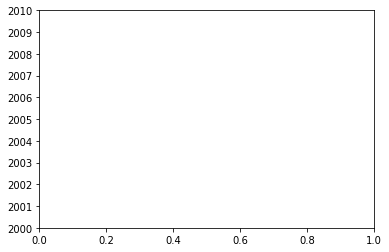

In [53]:
plt.plot(claims_data['Date Received'])

In [35]:
np.nansum(close_amount)

16642207.540000003

In [37]:
np.nanmean(close_amount)

95.054332223370906